In [0]:
a = []
while(1):
  a.append('1')

# Module Importing

In [1]:
!pip install catboost

     |████████████████████████████████| 64.8MB 67kB/s 


In [0]:
# import os
# os.chdir('..')

In [0]:
import gc

In [0]:
import datetime

In [0]:
import holidays

In [0]:
import pandas as pd
import numpy as np

In [0]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [0]:
import re

In [0]:
import lightgbm as lgb
import catboost
from catboost import Pool
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [0]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [0]:
from sklearn.preprocessing import LabelEncoder

In [0]:
from itertools import product

In [0]:
from tqdm import tqdm_notebook

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
sns.set(style="darkgrid")

In [0]:
import warnings
warnings.filterwarnings('ignore')

In [0]:
%matplotlib inline

# Data Loading

## Data fields
+ **ID** - an Id that represents a (Shop, Item) tuple within the test set
+ **shop_id** - unique identifier of a shop
+ **item_id** - unique identifier of a product
+ **item_category_id** - unique identifier of item category
+ **item_cnt_day** - number of products sold. You are predicting a monthly amount of this measure
+ **item_price** - current price of an item
+ **date** - date in format dd/mm/yyyy
+ **date_block_num** - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
+ **item_name** - name of item
+ **shop_name** - name of shop
+ **item_category_name** - name of item category

## Sales_train
**(the training set. Daily historical data from January 2013 to October 2015)**

In [0]:
sales_train_df = pd.read_csv('sales_train.csv', parse_dates=['date'], 
                             dtype={'date': 'str', 'date_block_num': 'int32', 'shop_id': 'int32', 
                                    'item_id': 'int32', 'item_price': 'float32', 'item_cnt_day': 'int32'})

In [19]:
sales_train_df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-02-01,0,59,22154,999.00,1
1,2013-03-01,0,25,2552,899.00,1
2,2013-05-01,0,25,2552,899.00,-1
3,2013-06-01,0,25,2554,1709.05,1
4,2013-01-15,0,25,2555,1099.00,1


In [20]:
print('Shape of sales_train.csv is (%d, %d)' % sales_train_df.shape)

Shape of sales_train.csv is (2935849, 6)


## Items
**(supplemental information about the items/products)**

In [0]:
items_df = pd.read_csv('items.csv', dtype={'item_name': 'str', 'item_id': 'int32', 
                                                 'item_category_id': 'int32'})

In [22]:
items_df.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [23]:
print('Shape of items.csv is (%d, %d)' % items_df.shape)

Shape of items.csv is (22170, 3)


## Item_categories
**(supplemental information about the items categories)**

In [0]:
item_categories_df = pd.read_csv('item_categories.csv', dtype={'item_category_name': 'str', 'item_category_id': 'int32'})

In [25]:
item_categories_df.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [26]:
print('Shape of item_categories.csv is (%d, %d)' % item_categories_df.shape)

Shape of item_categories.csv is (84, 2)


## Shops
**(supplemental information about the shops)**

In [0]:
shops_df = pd.read_csv('shops.csv', dtype={'shop_name': 'str', 'shop_id': 'int32'})

In [28]:
shops_df.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [29]:
print('Shape of shops.csv is (%d, %d)' % shops_df.shape)

Shape of shops.csv is (60, 2)


## test
**(the test set. You need to forecast the sales for these shops and products for November 2015)**

In [0]:
test_df = pd.read_csv('test.csv', dtype={'ID': 'int32', 'shop_id': 'int32', 
                                              'item_id': 'int32'})

In [31]:
test_df.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [32]:
print('Shape of test.csv is (%d, %d)' % test_df.shape)

Shape of test.csv is (214200, 3)


# Basic EDA

In [0]:
def intitial_eda_checks(df: pd.DataFrame) -> None:
    """
        1. Take a dataframe.
        2. Check if there is duplicates.
        3. Check if there is nulls.
    """

    # keep=False - marke all duplicates as True
    if len(df[df.duplicated(keep=False)]) > 0:
        print('- Number of duplicates = {}'.format(len(df[df.duplicated(keep=False)])))
    else:
        print('- No duplicates found.')

    if df.isnull().sum().sum() > 0:
        mask_total = df.isnull().sum().sort_values(ascending=False) 
        total = mask_total[mask_total > 0]

        mask_percent = df.isnull().mean().sort_values(ascending=False) 
        percent = mask_percent[mask_percent > 0] 

        missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    
        print(f'- Total and Percentage of NaN:\n {missing_data}')
    else: 
        print('- No NaN found.')

### Descriptive statistics, number of missing values, etc

**First and last 5 rows of DataFrame:**

In [0]:
sales_train_df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [0]:
sales_train_df.tail()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2935844,10.10.2015,33,25,7409,299.0,1.0
2935845,09.10.2015,33,25,7460,299.0,1.0
2935846,14.10.2015,33,25,7459,349.0,1.0
2935847,22.10.2015,33,25,7440,299.0,1.0
2935848,03.10.2015,33,25,7460,299.0,1.0


**Basic information about a DataFrame:**

In [0]:
sales_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [0]:
intitial_eda_checks(sales_train_df)

- Number of duplicates = 12
- No NaN found.


In [0]:
print('- Number of unique items = ',
      len(sales_train_df['item_id'].unique()))
print('- Number of unique items, which appears only once  = ',
      len(sales_train_df['item_id'].value_counts()[sales_train_df['item_id'].value_counts() == 1]))
print('- Number of unique items, which appears less or equal than 10 times  = ', 
      len(sales_train_df['item_id'].value_counts()[sales_train_df['item_id'].value_counts() < 10]))

- Number of unique items =  21807
- Number of unique items, which appears only once  =  2371
- Number of unique items, which appears less or equal than 10 times  =  6541


In [0]:
print('- Number of unique shops = ',
      len(sales_train_df['shop_id'].unique()))
print('- Number of unique shops, which appears only once  = ',
      len(sales_train_df['shop_id'].value_counts()[sales_train_df['shop_id'].value_counts() == 1]))
print('- Number of unique shops, which appears less or equal than 10000 times  = ', 
      len(sales_train_df['shop_id'].value_counts()[sales_train_df['shop_id'].value_counts() < 10000]))

- Number of unique shops =  60
- Number of unique shops, which appears only once  =  0
- Number of unique shops, which appears less or equal than 10000 times  =  12


In [0]:
len(sales_train_df['item_id'].value_counts()[sales_train_df['item_id'].value_counts() == 1])

2371

**Top-10 popular items:**

In [0]:
top_10_items = pd.DataFrame(sales_train_df.merge(items_df, left_on='item_id', right_on='item_id')['item_name'].value_counts()[:50]).reset_index()
top_10_items.columns = ['item_name', 'count']

In [0]:
top_10_items.head(10)

,item_name,count
0,Фирменный пакет майка 1С Интерес белый (34*42)...,31340
1,Playstation Store пополнение бумажника: Карта ...,9408
2,Прием денежных средств для 1С-Онлайн,9067
3,"Diablo III [PC, Jewel, русская версия]",7479
4,Kaspersky Internet Security Multi-Device Russi...,6853
5,World of Warcraft. Карта оплаты игрового време...,6602
6,"Grand Theft Auto V [PS3, русские субтитры]",6475
7,"Call of Duty: Black Ops II [PС, Jewel, русская...",6320
8,"Minecraft [Xbox 360, английская версия]",5811
9,"Grand Theft Auto V [Xbox 360, русские субтитры]",5805


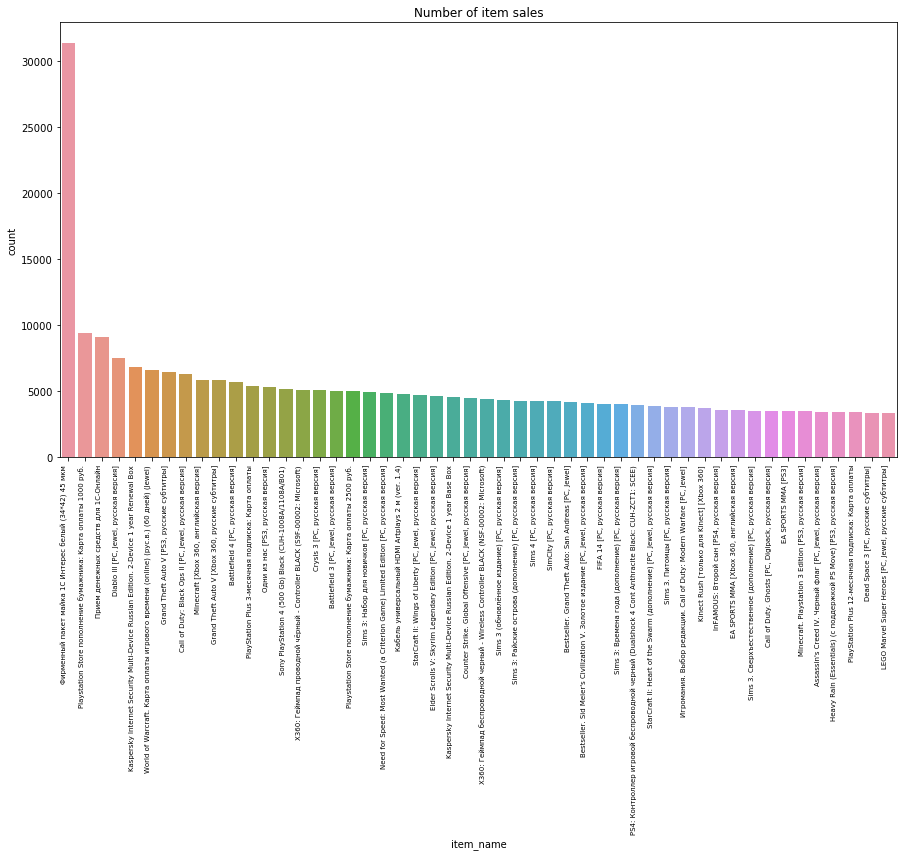

In [0]:
fig, ax = plt.subplots(1, 1, figsize = (15, 8))
sns.barplot(x="item_name", y='count', data=top_10_items)
ax.set_title("Number of item sales");
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right", fontsize=7);

In [0]:
del top_10_items

**Top-10 popular categories:**

In [0]:
top_10_categories = pd.DataFrame(sales_train_df.merge(items_df, left_on='item_id', right_on='item_id') \
                                               .merge(item_categories_df, left_on='item_category_id', right_on='item_category_id')['item_category_name'] \
                                               .value_counts() \
                                               .reset_index()[:50]
            )
top_10_categories.columns = ['caterory_name', 'count']

In [0]:
top_10_categories.head(10)

,caterory_name,count
0,Кино - DVD,564652
1,Игры PC - Стандартные издания,351591
2,Музыка - CD локального производства,339585
3,Игры - PS3,208219
4,Кино - Blu-Ray,192674
5,Игры - XBOX 360,146789
6,Игры PC - Дополнительные издания,121539
7,Игры - PS4,79058
8,Подарки - Мягкие игрушки,53845
9,Подарки - Настольные игры (компактные),53227


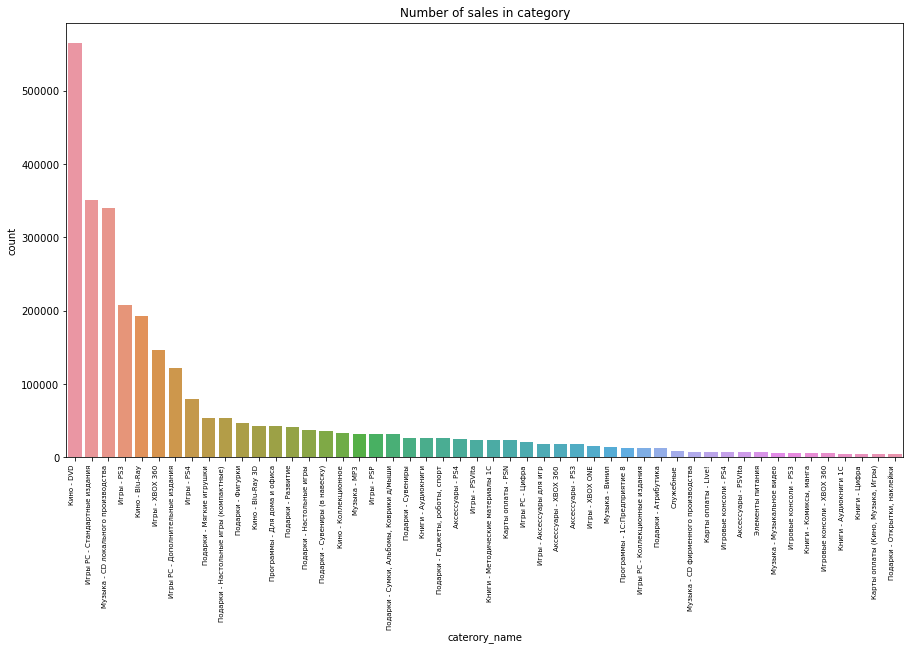

In [0]:
fig, ax = plt.subplots(1, 1, figsize = (15, 8))
sns.barplot(x="caterory_name", y='count', data=top_10_categories)
ax.set_title("Number of sales in category");
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right", fontsize=7);

In [0]:
del top_10_categories

**Top-10 popular shops:**

In [0]:
top_10_shops = pd.DataFrame(sales_train_df.merge(shops_df, left_on='shop_id', right_on='shop_id')['shop_name'] \
                                          .value_counts() \
                                          .reset_index()[:50])
top_10_shops.columns = ['shop_name', 'count']

In [0]:
top_10_shops.head(10)

,shop_name,count
0,"Москва ТЦ ""Семеновский""",235636
1,"Москва ТРК ""Атриум""",186104
2,"Химки ТЦ ""Мега""",143480
3,"Москва ТЦ ""МЕГА Теплый Стан"" II",142234
4,"Якутск Орджоникидзе, 56",117428
5,"СПб ТК ""Невский Центр""",109253
6,"Москва ТЦ ""МЕГА Белая Дача II""",105366
7,"Воронеж (Плехановская, 13)",82663
8,"Якутск ТЦ ""Центральный""",71441
9,"Чехов ТРЦ ""Карнавал""",69573


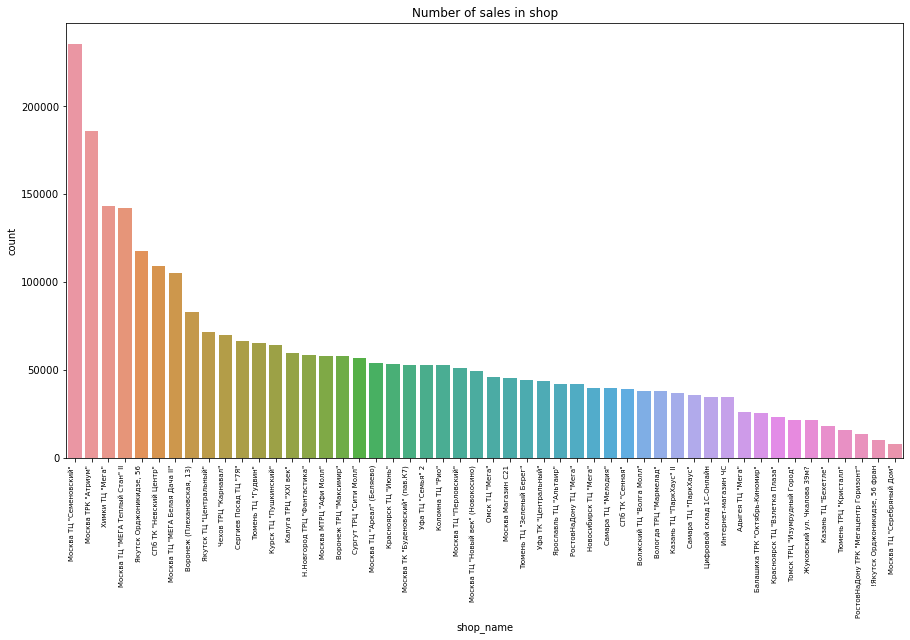

In [0]:
fig, ax = plt.subplots(1, 1, figsize = (15, 8))
sns.barplot(x="shop_name", y='count', data=top_10_shops)
ax.set_title("Number of sales in shop");
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right", fontsize=7);

In [0]:
del top_10_shops

**Monthly and daily sales:**

In [0]:
sales = sales_train_df.copy()

In [0]:
def revers_date(x: str):
    buf = x.split('.')
    return '.'.join([buf[2], buf[1], buf[0]])

In [0]:
sales['date'] = sales['date'].apply(revers_date)

In [0]:
sales.date.values.sort()

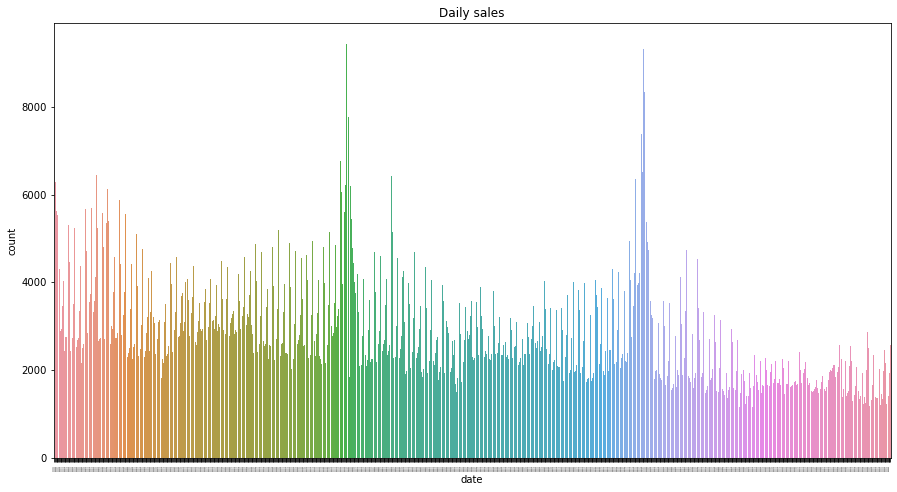

In [0]:
fig, ax = plt.subplots(1, 1, figsize = (15, 8))
sns.countplot(x="date", data=sales, ax=ax)
ax.set_title("Daily sales");
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right", fontsize=0);

In [0]:
sales['date'] = sales['date'].apply(lambda x: x[:-3])

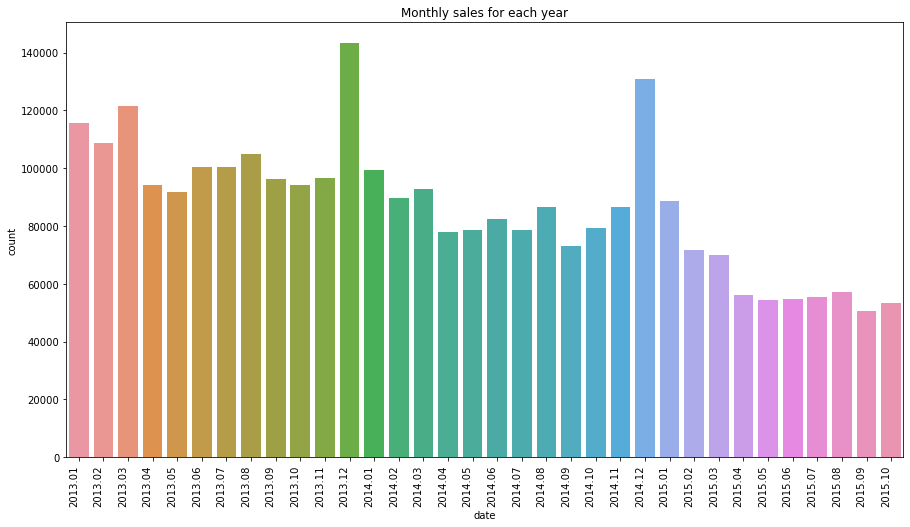

In [0]:
fig, ax = plt.subplots(1, 1, figsize = (15,8))
sns.countplot(x="date", data=sales, ax=ax)
ax.set_title("Monthly sales for each year");
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right");

In [0]:
sales['date'] = sales['date'].apply(lambda x: x[-2:])

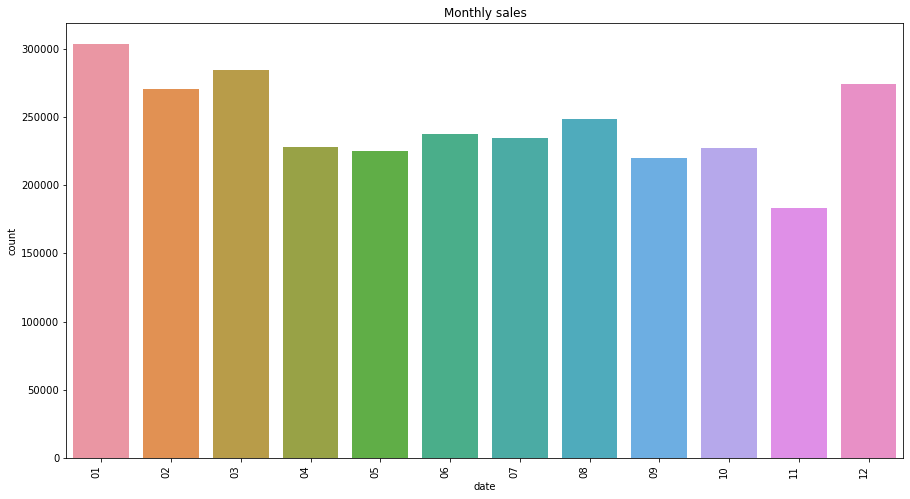

In [0]:
fig, ax = plt.subplots(1, 1, figsize = (15,8))
sns.countplot(x="date", data=sales, ax=ax)
ax.set_title("Monthly sales");
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right");

In [0]:
del sales

**How sales behaves along the year?**

In [0]:
monthly_sales = sales_train_df.copy()

In [0]:
monthly_sales = monthly_sales.sort_values('date').groupby(['date_block_num', 'shop_id', 'item_id'], as_index=False)

In [0]:
monthly_sales = monthly_sales.agg({'item_price':['sum', 'mean'], 'item_cnt_day':['sum', 'mean','count']})

In [0]:
monthly_sales.columns = ['date_block_num', 'shop_id', 'item_id', 'item_price', 'mean_item_price', 'item_cnt', 'mean_item_cnt', 'transactions']

In [0]:
monthly_sales['year'] = monthly_sales['date_block_num'].apply(lambda x: ((x//12) + 2013))
monthly_sales['month'] = monthly_sales['date_block_num'].apply(lambda x: (x % 12))

In [0]:
monthly_sales.head()

,date_block_num,shop_id,item_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions
0,0,0,32,884.0,221.0,6.0,1.5,4
1,0,0,33,1041.0,347.0,3.0,1.0,3
2,0,0,35,247.0,247.0,1.0,1.0,1
3,0,0,43,221.0,221.0,1.0,1.0,1
4,0,0,51,257.0,128.5,2.0,1.0,2


In [0]:
gp_month_mean = monthly_sales.groupby(['month'], as_index=False)['item_cnt'].mean()
gp_month_sum = monthly_sales.groupby(['month'], as_index=False)['item_cnt'].sum()

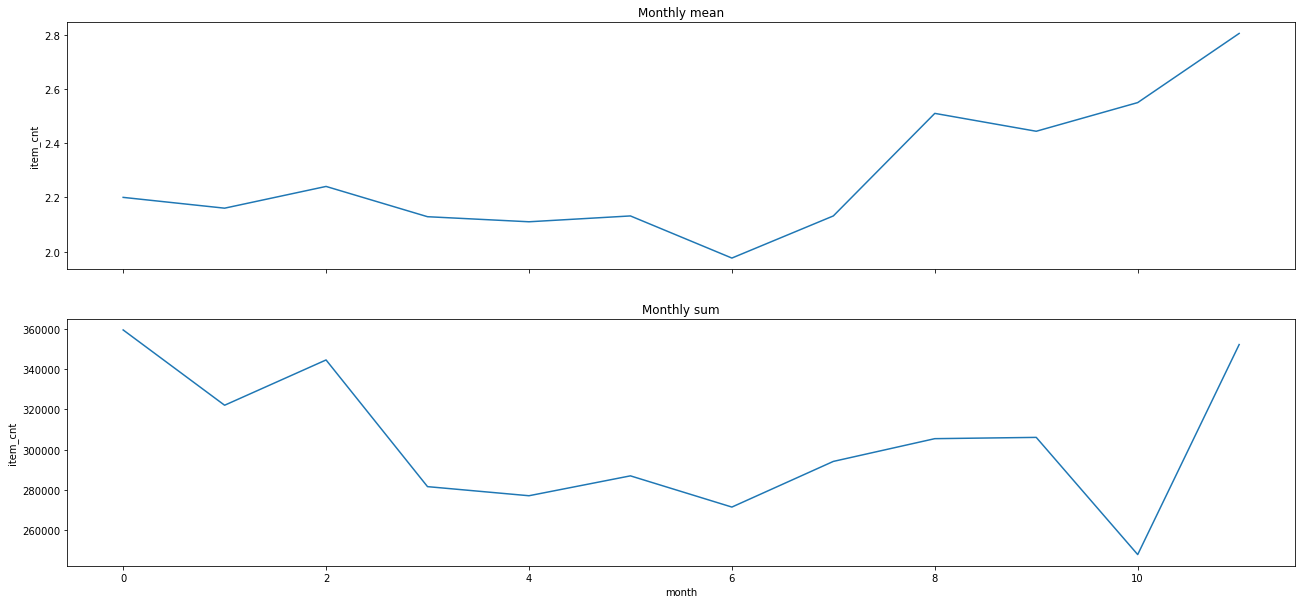

In [0]:
f, axes = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.lineplot(x="month", y="item_cnt", data=gp_month_mean, ax=axes[0]).set_title("Monthly mean")
sns.lineplot(x="month", y="item_cnt", data=gp_month_sum, ax=axes[1]).set_title("Monthly sum")
plt.show()

In [0]:
del gp_month_mean, gp_month_sum

**What shop sells more?**

In [0]:
gp_shop_mean = monthly_sales.groupby(['shop_id'], as_index=False)['item_cnt'].mean()
gp_shop_sum = monthly_sales.groupby(['shop_id'], as_index=False)['item_cnt'].sum()

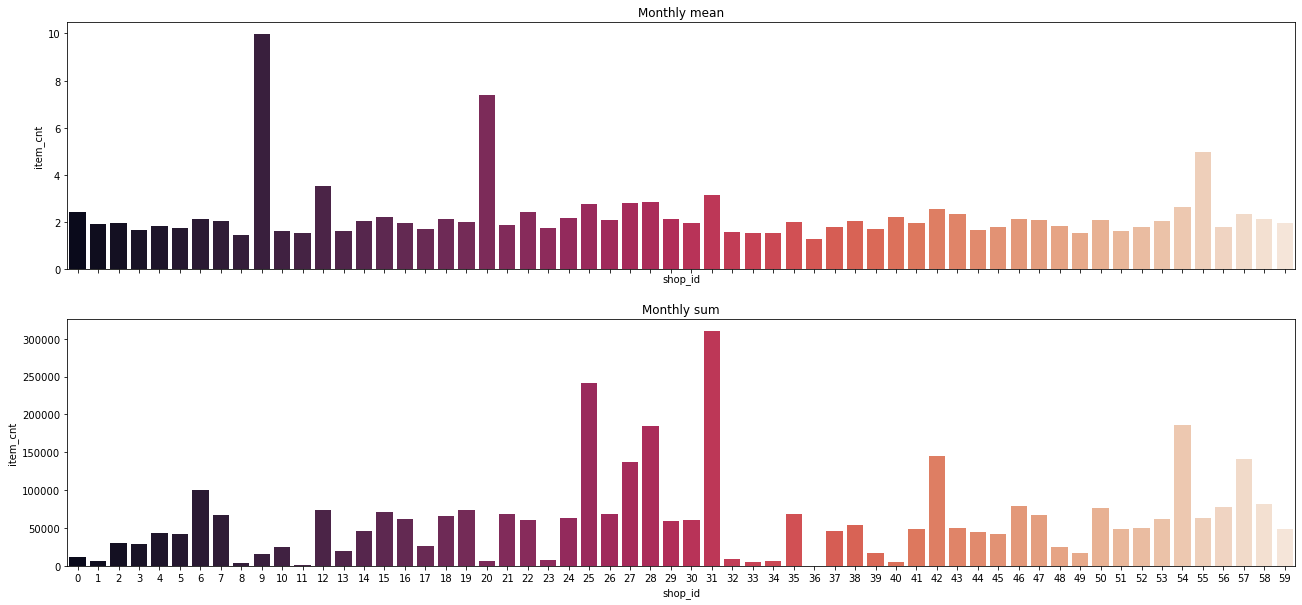

In [0]:
f, axes = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.barplot(x="shop_id", y="item_cnt", data=gp_shop_mean, ax=axes[0], palette="rocket").set_title("Monthly mean")
sns.barplot(x="shop_id", y="item_cnt", data=gp_shop_sum, ax=axes[1], palette="rocket").set_title("Monthly sum")
plt.show()

In [0]:
del gp_shop_mean, gp_shop_sum

**Checking for outliers:**

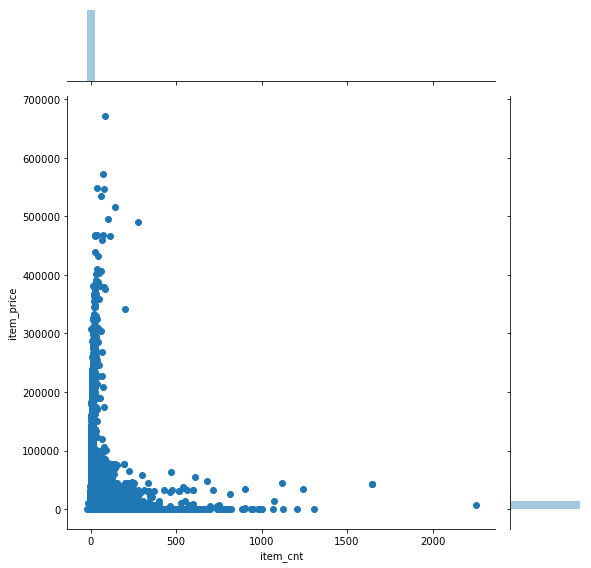

In [0]:
sns.jointplot(x="item_cnt", y="item_price", data=monthly_sales, height=8)

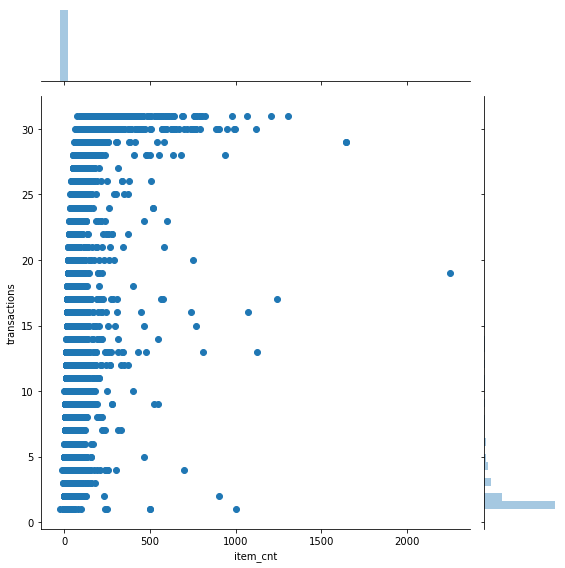

In [0]:
sns.jointplot(x="item_cnt", y="transactions", data=monthly_sales, height=8)

**Feature "item_cnt" distribution:**

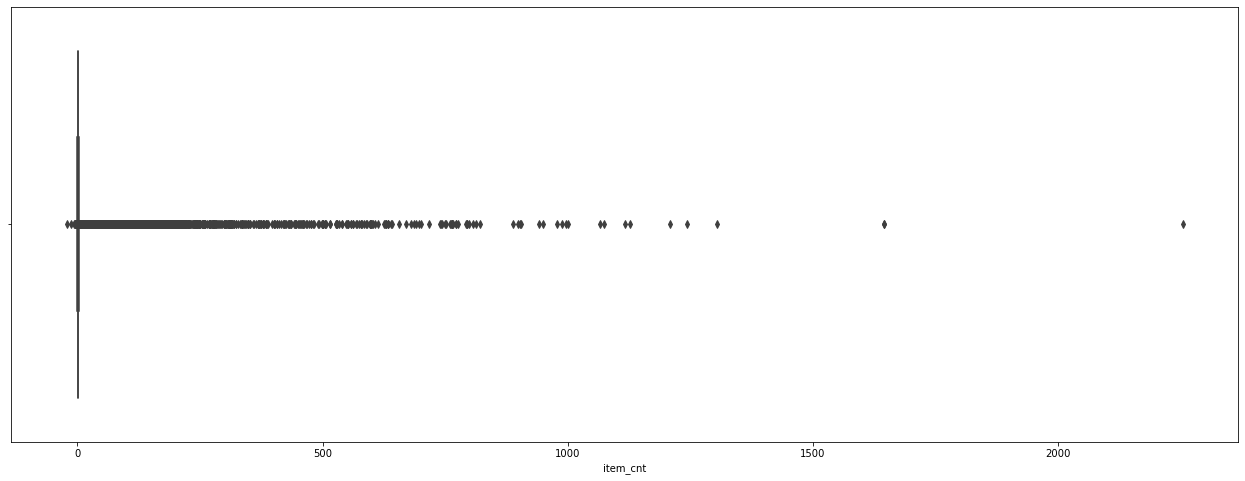

In [0]:
plt.subplots(figsize=(22, 8))
sns.boxplot(monthly_sales['item_cnt'])
plt.show()

In [0]:
del monthly_sales

**Number of item sales per month for each shop:**

In [0]:
grouped = pd.DataFrame(sales_train_df.groupby(['shop_id', 'date_block_num'])['item_cnt_day'].sum().reset_index())

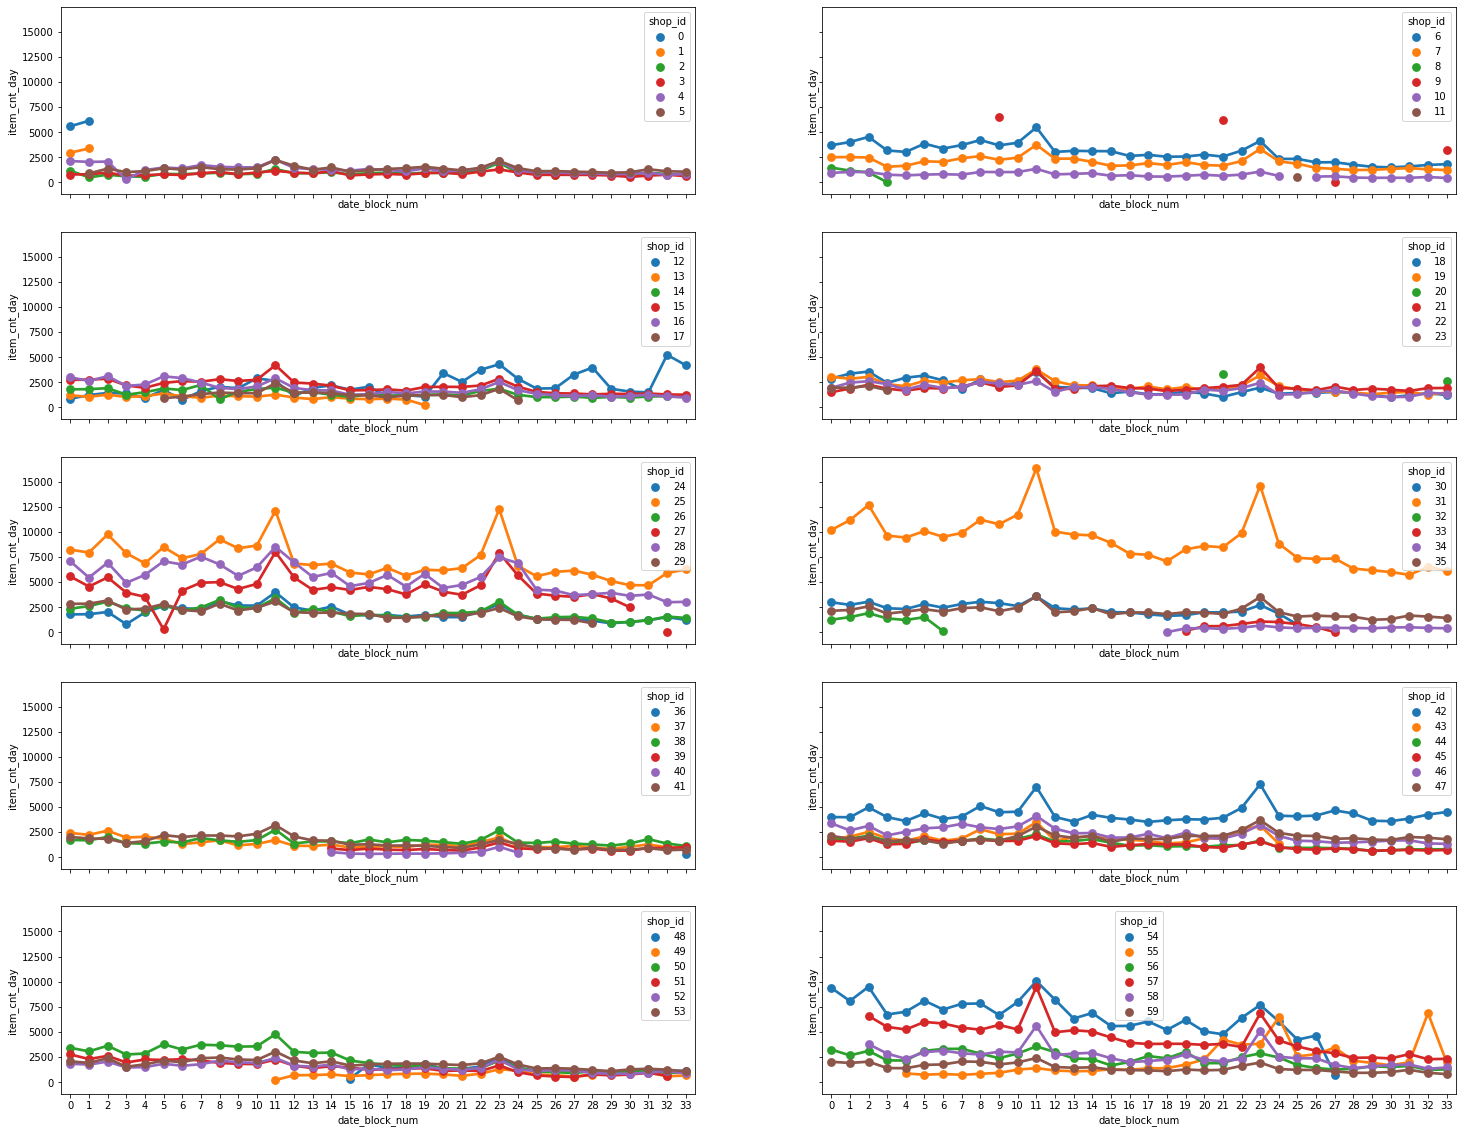

In [0]:
num_graph = 10
count = 0

fig, axes = plt.subplots(nrows=5, ncols=2, sharex=True, sharey=True, figsize=(25,20))
id_per_graph = np.ceil(grouped.shop_id.max() / num_graph)

for i in range(5):
    for j in range(2):
        sns.pointplot(x='date_block_num', y='item_cnt_day', hue='shop_id',
                      data=grouped[np.logical_and(count*id_per_graph <= grouped['shop_id'], grouped['shop_id'] < (count+1)*id_per_graph)],
                      ax=axes[i][j])
        count += 1

In [0]:
del grouped

In [0]:
gc.collect()

30

# Basic data preparation

In [0]:
def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

### Adding revenue column

In [0]:
# sales_train_df['revenue'] = sales_train_df['item_price'] * sales_train_df['item_cnt_day']

In [0]:
# sales_train_df.head()

### Join datasets

In [0]:
# train = sales_train_df.join(items_df, on='item_id', rsuffix='_') \
#                       .join(shops_df, on='shop_id', rsuffix='_') \
#                       .join(item_categories_df, on='item_category_id', rsuffix='_') \
#                       .drop(['item_id_', 'shop_id_', 'item_category_id_'], axis=1)

### Time period of the dataset

In [33]:
print('Min date from train set: %s' % sales_train_df['date'].min().date())
print('Max date from train set: %s' % sales_train_df['date'].max().date())

Min date from train set: 2013-01-01
Max date from train set: 2015-12-10


### Extract month and year from 'date_block_num'

In [0]:
sales_train_df['year'] = sales_train_df['date_block_num'].apply(lambda x: ((x//12) + 2013))
sales_train_df['month'] = sales_train_df['date_block_num'].apply(lambda x: (x % 12))

### Date column to correct format

In [0]:
# sales_train_df['date'] = sales_train_df['date'].apply(lambda x: datetime.datetime.strptime(x, '%d.%m.%Y'))

### Adding information about category

In [0]:
sales_train_df = sales_train_df.join(items_df, on='item_id', rsuffix='_').drop(['item_id_', 'item_name'], axis=1)

### Filling negative price

In [0]:
median = sales_train_df[(sales_train_df.shop_id==32)&
                        (sales_train_df.item_id==2973)&
                        (sales_train_df.date_block_num==4)&
                        (sales_train_df.item_price>0)].item_price.median()
sales_train_df.loc[sales_train_df.item_price<0, 'item_price'] = median

### Fixing shops duplicates

In [0]:
# Якутск Орджоникидзе, 56
sales_train_df.loc[sales_train_df.shop_id == 0, 'shop_id'] = 57
test_df.loc[test_df.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
sales_train_df.loc[sales_train_df.shop_id == 1, 'shop_id'] = 58
test_df.loc[test_df.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
sales_train_df.loc[sales_train_df.shop_id == 10, 'shop_id'] = 11
test_df.loc[test_df.shop_id == 10, 'shop_id'] = 11

### Dropping duplicates

In [0]:
subset = ['date','date_block_num','shop_id','item_id','item_cnt_day']

In [40]:
print('Duplicates: {}'.format(sales_train_df.duplicated(subset=subset).sum()))

Duplicates: 24


In [0]:
sales_train_df.drop_duplicates(subset=subset, inplace=True)

### Dropping negative price

In [0]:
# sales_train_df = sales_train_df.query('item_price > 0')

### Data leakages. Dropping shops and items not in test data

In [0]:
# test_shops = test_df.shop_id.unique()
# test_items = test_df.item_id.unique()

In [0]:
# train = sales_train_df[sales_train_df.shop_id.isin(test_shops)]
# train = sales_train_df[sales_train_df.item_id.isin(test_items)]

In [0]:
# del test_shops, test_items

In [0]:
# gc.collect()

### Creating all combinations

In [47]:
len(list(set(test_df.item_id) - set(test_df.item_id).intersection(set(sales_train_df.item_id)))), len(list(set(test_df.item_id))), len(test_df)

(363, 5100, 214200)

In [48]:
%%time

matrix = []
cols = ['date_block_num','shop_id','item_id']
for i in range(34):
    sales = sales_train_df[sales_train_df.date_block_num==i]
    matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))
    
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols,inplace=True)

CPU times: user 10.7 s, sys: 790 ms, total: 11.5 s
Wall time: 11.5 s


### Adding revenue column

In [0]:
sales_train_df['revenue'] = sales_train_df['item_price'] * sales_train_df['item_cnt_day']

### Creating target label

In [50]:
%%time

group = sales_train_df.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=cols, how='left')
matrix['item_cnt_month'] = (matrix['item_cnt_month']
                                .fillna(0)
                                .clip(0,20) # NB clip target here
                                .astype(np.float16))

CPU times: user 4.46 s, sys: 408 ms, total: 4.87 s
Wall time: 4.8 s


### Preparing test set

In [0]:
test_df['date_block_num'] = 34
test_df['date_block_num'] = test_df['date_block_num'].astype(np.int8)
test_df['shop_id'] = test_df['shop_id'].astype(np.int8)
test_df['item_id'] = test_df['item_id'].astype(np.int16)

### Adding test set to matrix

In [0]:
matrix = pd.concat([matrix, test_df], ignore_index=True, sort=False, keys=cols)
matrix.fillna(0, inplace=True) # 34 month

### Adding month and year columns

In [0]:
# train_monthly['year'] = train_monthly['date_block_num'].apply(lambda x: ((x//12) + 2013))
# train_monthly['month'] = train_monthly['date_block_num'].apply(lambda x: (x % 12))

### Removing outliers

In [0]:
# train_month['item_cnt'].clip(0, 20, inplace=True)

In [0]:
# train_monthly = train_monthly.query('item_cnt >= 0 and item_cnt <= 20 and item_price < 400000')

### Creating target label

In [0]:
# try without shift

In [0]:
# train_monthly['item_cnt_month'] = train_monthly.sort_values('date_block_num').groupby(['shop_id', 'item_id'])['item_cnt'].shift(0)

# Feature creation

### Simple text features

In [58]:
shops_df.loc[shops_df.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'

shops_df['city'] = shops_df['shop_name'].str.split(' ').map(lambda x: x[0])
shops_df['category'] = shops_df['shop_name'].str.split(' ').map(lambda x:x[1]).astype(str)

shops_df.loc[shops_df.city == '!Якутск', 'city'] = 'Якутск'

category = ['Орджоникидзе,', 'ТЦ', 'ТРК', 'ТРЦ','ул.', 'Магазин', 'ТК', 'склад']
shops_df.category = shops_df.category.apply(lambda x: x if (x in category) else 'etc')
shops_df.category.unique()

array(['Орджоникидзе,', 'ТЦ', 'ТРК', 'ТРЦ', 'etc', 'ул.', 'Магазин', 'ТК',
       'склад'], dtype=object)

In [59]:
category = ['ТЦ', 'ТРК', 'ТРЦ', 'ТК']
shops_df.category = shops_df.category.apply(lambda x: x if (x in category) else 'etc')
print('Category Distribution', shops_df.groupby(['category']).sum())

Category Distribution           shop_id
category         
etc           223
ТК            184
ТРК           140
ТРЦ           340
ТЦ            883


In [60]:
shops_df['shop_city'] = shops_df.city
shops_df['shop_category'] = shops_df.category

shops_df['shop_city'] = LabelEncoder().fit_transform(shops_df['shop_city'])
shops_df['shop_category'] = LabelEncoder().fit_transform(shops_df['shop_category'])

shops_df = shops_df[['shop_id','shop_city', 'shop_category']]
shops_df.head()

,shop_id,shop_city,shop_category
0,0,29,0
1,1,29,4
2,2,0,4
3,3,1,2
4,4,2,4


In [61]:
item_categories_df['type_code'] = item_categories_df.item_category_name.apply(lambda x: x.split(' ')[0]).astype(str)
item_categories_df.loc[(item_categories_df.type_code == 'Игровые') | (item_categories_df.type_code == 'Аксессуары'), 'category'] = 'Игры'
item_categories_df.loc[item_categories_df.type_code == 'PC', 'category'] = 'Музыка'

category = ['Игры', 'Карты', 'Кино', 'Книги','Музыка', 'Подарки', 'Программы', 'Служебные', 'Чистые']

item_categories_df['type_code'] = item_categories_df.type_code.apply(lambda x: x if (x in category) else 'etc')

print(item_categories_df.groupby(['type_code']).sum())
item_categories_df['type_code'] = LabelEncoder().fit_transform(item_categories_df['type_code'])

item_categories_df['split'] = item_categories_df.item_category_name.apply(lambda x: x.split('-'))
item_categories_df['subtype'] = item_categories_df['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
item_categories_df['subtype_code'] = LabelEncoder().fit_transform(item_categories_df['subtype'])
item_categories_df = item_categories_df[['item_category_id','type_code', 'subtype_code']]

           item_category_id
type_code                  
etc                     236
Игры                    343
Карты                   170
Кино                    195
Книги                   624
Музыка                  345
Подарки                 798
Программы               453
Служебные               159
Чистые                  163


In [62]:
from collections import Counter
from operator import itemgetter

items_df['name_1'], items_df['name_2'] = items_df['item_name'].str.split('[', 1).str
items_df['name_1'], items_df['name_3'] = items_df['item_name'].str.split('(', 1).str

items_df['name_2'] = items_df['name_2'].str.replace('[^A-Za-z0-9А-Яа-я]+', ' ').str.lower()
items_df['name_3'] = items_df['name_3'].str.replace('[^A-Za-z0-9А-Яа-я]+', ' ').str.lower()
items_df = items_df.fillna('0')

result_1 = Counter(' '.join(items_df['name_2'].values.tolist()).split(' ')).items()
result_1 = sorted(result_1, key=itemgetter(1))
result_1 = pd.DataFrame(result_1, columns=['feature', 'count'])
result_1 = result_1[(result_1['feature'].str.len() > 1) & (result_1['count'] > 200)]

result_2 = Counter(' '.join(items_df['name_3'].values.tolist()).split(" ")).items()
result_2 = sorted(result_2, key=itemgetter(1))
result_2 = pd.DataFrame(result_2, columns=['feature', 'count'])
result_2 = result_2[(result_2['feature'].str.len() > 1) & (result_2['count'] > 200)]

result = pd.concat([result_1, result_2])
result = result.drop_duplicates(subset=['feature']).reset_index(drop=True)

print('Most common aditional features:', result)

def name_correction(x):
    x = x.lower()
    x = x.partition('[')[0]
    x = x.partition('(')[0]
    x = re.sub('[^A-Za-z0-9А-Яа-я]+', ' ', x)
    x = x.replace('  ', ' ')
    x = x.strip()
    return x

items_df['item_name'] = items_df['item_name'].apply(lambda x: name_correction(x))
items_df.name_2 = items_df.name_2.apply(lambda x: x[:-1] if x != '0' else '0')

Most common aditional features:          feature  count
0   документация    284
1     английская    340
2        русские    399
3       субтитры    400
4            360    465
5          jewel    552
6           xbox    589
7            ps3    611
8        русская   1428
9       цифровая   1995
10            pc   2585
11        версия   3427
12           box    246
13            3d    409
14           dvd    503
15      digipack    541
16          фирм    757
17           mp3    854
18            cd    871
19        регион   1849
20            bd   2320


In [63]:
items_df['type'] = items_df.name_2.apply(lambda x: x[0:8] if x.split(' ')[0] == 'xbox' else x.split(' ')[0])
items_df.loc[(items_df.type == 'x360') | (items_df.type == 'xbox360'), 'type'] = 'xbox 360'
items_df.loc[items_df.type == '', 'type'] = 'mac'
items_df.type = items_df.type.apply(lambda x: x.replace(' ',''))
items_df.loc[(items_df.type == 'pc') | (items_df.type == 'pс') | (items_df.type == 'рс'), 'type'] = 'pc'
items_df.loc[(items_df.type == 'рs3'), 'type'] = 'ps3'

group_sum = items_df.groupby('type').sum()
group_sum.loc[group_sum.item_category_id < 200]

,item_id,item_category_id
type,,
5c5,12118,16
5c7,26808,32
5f4,7936,7
6dv,7934,7
6jv,7924,7
6l6,7935,7
android,12994,78
hm3,7926,7
j72,31709,28


In [64]:
drop_list = ['5c5', '5c7', '5f4', '6dv', '6jv', '6l6', 'android', 'hm3', 'j72', 'kf6', 'kf7','kg4',
            'ps2', 's3v', 's4v'	,'англ', 'русская', 'только', 'цифро']

items_df.name_2 = items_df.type.apply(lambda x: 'etc' if x in drop_list else x)
items_df = items_df.drop(['type'], axis=1)
items_df.groupby('name_2').sum()

,item_id,item_category_id
name_2,,
0,218310960,872182
etc,253458,550
mac,148743,2323
pc,16991083,106924
ps,431537,1738
ps3,3531772,11422
ps4,895981,3489
psp,692947,2415
xbox360,2362398,10718


In [65]:
items_df['name_2'] = LabelEncoder().fit_transform(items_df['name_2'])
items_df['name_3'] = LabelEncoder().fit_transform(items_df['name_3'])
items_df.drop(['item_name', 'name_1'], axis=1, inplace=True)
items_df.head()

,item_id,item_category_id,name_2,name_3
0,0,40,0,1331
1,1,76,3,42
2,2,40,0,1011
3,3,40,0,1010
4,4,40,0,1572


In [0]:
matrix = matrix.merge(shops_df, on=['shop_id'])
matrix = matrix.merge(items_df, on=['item_id'])
matrix = matrix.merge(item_categories_df, on=['item_category_id'])

In [0]:
matrix['shop_city'] = matrix['shop_city'].astype(np.int8)
matrix['shop_category'] = matrix['shop_category'].astype(np.int8)
matrix['item_category_id'] = matrix['item_category_id'].astype(np.int8)
matrix['type_code'] = matrix['type_code'].astype(np.int8)
matrix['subtype_code'] = matrix['subtype_code'].astype(np.int8)
matrix['name_2'] = matrix['name_2'].astype(np.int32)
matrix['name_3'] = matrix['name_3'].astype(np.int32)

### Historical min/max price

In [0]:
gp_item_price = sales_train_df.sort_values('date_block_num').groupby(['item_id'], as_index=False).agg({'item_price':[np.min, np.max]})
gp_item_price.columns = ['item_id', 'hist_min_item_price', 'hist_max_item_price']

matrix = pd.merge(matrix, gp_item_price, on='item_id', how='left')

In [0]:
matrix['hist_min_item_price'] = matrix['hist_min_item_price'].astype(np.float16)
matrix['hist_max_item_price'] = matrix['hist_max_item_price'].astype(np.float16)

In [70]:
del gp_item_price
gc.collect()

41

### Date features

In [0]:
matrix['month'] = matrix['date_block_num'] % 12

In [0]:
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix['days'] = matrix['month'].map(days).astype(np.int8)

### Months since the last sale or each shop/item pair

In [0]:
cache = {}
matrix['item_shop_last_sale'] = -1
matrix['item_shop_last_sale'] = matrix['item_shop_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():    
    key = str(row.item_id)+' '+str(row.shop_id)
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        matrix.at[idx, 'item_shop_last_sale'] = row.date_block_num - last_date_block_num
        cache[key] = row.date_block_num 

### Months since the last sale or each item only

In [0]:
cache = {}
matrix['item_last_sale'] = -1
matrix['item_last_sale'] = matrix['item_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():    
    key = row.item_id
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        if row.date_block_num>last_date_block_num:
            matrix.at[idx, 'item_last_sale'] = row.date_block_num - last_date_block_num
            cache[key] = row.date_block_num  

### Months since the first sale for each shop/item pair and for item only

In [0]:
matrix['item_shop_first_sale'] = matrix['date_block_num'] - matrix.groupby(['item_id','shop_id'])['date_block_num'].transform('min')
matrix['item_first_sale'] = matrix['date_block_num'] - matrix.groupby('item_id')['date_block_num'].transform('min')

### Rolling windows based features

In [0]:
gp = matrix.sort_values('date_block_num').groupby(['shop_id', 'item_category_id', 'item_id'])['item_cnt_month']

In [77]:
# Min value
f_min = lambda x: x.rolling(window=3, min_periods=1).min()
# Max value
f_max = lambda x: x.rolling(window=3, min_periods=1).max()

function_list = [f_min, f_max]
function_name = ['min', 'max']

for i in tqdm_notebook(range(len(function_list))):
    matrix[('item_cnt_%s' % function_name[i])] = gp.apply(function_list[i]).astype(np.float16)

In [78]:
# Mean value
f_mean = lambda x: x.rolling(window=3, min_periods=1).mean()
# Standard deviation
f_std = lambda x: x.rolling(window=3, min_periods=1).std()

function_list = [f_mean, f_std]
function_name = ['mean', 'std']

for i in tqdm_notebook(range(len(function_list))):
    matrix[('item_cnt_%s' % function_name[i])] = gp.apply(function_list[i]).astype(np.float16)

# Fill the empty std features with 0
matrix['item_cnt_std'].fillna(0, inplace=True)

In [79]:
del gp
gc.collect()

3

#### Target lags features

In [0]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [0]:
# check name for lag and trend feature

In [0]:
lag_list = [1, 2, 3, 4, 5, 6, 12]

In [83]:
%%time

matrix = lag_feature(matrix, [1,2,3,6,12], 'item_cnt_month')

CPU times: user 34.3 s, sys: 588 ms, total: 34.9 s
Wall time: 34.9 s


# Mean and Var encoding

In [0]:
group = matrix.groupby(['date_block_num']).agg({'item_cnt_month': ['mean', 'var']})
group.columns = [ 'date_avg_item_cnt', 'date_var_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num'], how='left')
matrix['date_avg_item_cnt'] = matrix['date_avg_item_cnt'].astype(np.float16)
matrix['date_var_item_cnt'] = matrix['date_var_item_cnt'].astype(np.float16)

matrix = lag_feature(matrix, [1], 'date_avg_item_cnt')
matrix = lag_feature(matrix, [1], 'date_var_item_cnt')

matrix.drop(['date_avg_item_cnt'], axis=1, inplace=True)
matrix.drop(['date_var_item_cnt'], axis=1, inplace=True)

In [0]:
group = matrix.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean', 'var']})
group.columns = [ 'date_item_avg_item_cnt', 'date_item_var_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_cnt'] = matrix['date_item_avg_item_cnt'].astype(np.float16)
matrix['date_item_var_item_cnt'] = matrix['date_item_var_item_cnt'].astype(np.float16)

matrix = lag_feature(matrix, [1,2,3,6,12], 'date_item_avg_item_cnt')
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_item_var_item_cnt')

matrix.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)
matrix.drop(['date_item_var_item_cnt'], axis=1, inplace=True)

In [0]:
group = matrix.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['mean', 'var']})
group.columns = [ 'date_shop_avg_item_cnt', 'date_shop_var_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_avg_item_cnt'] = matrix['date_shop_avg_item_cnt'].astype(np.float16)
matrix['date_shop_var_item_cnt'] = matrix['date_shop_var_item_cnt'].astype(np.float16)

matrix = lag_feature(matrix, [1,2,3,6,12], 'date_shop_avg_item_cnt')
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_shop_var_item_cnt')

matrix.drop(['date_shop_avg_item_cnt'], axis=1, inplace=True)
matrix.drop(['date_shop_var_item_cnt'], axis=1, inplace=True)

In [0]:
group = matrix.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean', 'var']})
group.columns = [ 'date_cat_avg_item_cnt', 'date_cat_var_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_category_id'], how='left')
matrix['date_cat_avg_item_cnt'] = matrix['date_cat_avg_item_cnt'].astype(np.float16)
matrix['date_cat_var_item_cnt'] = matrix['date_cat_var_item_cnt'].astype(np.float16)

matrix = lag_feature(matrix, [1], 'date_cat_avg_item_cnt')
matrix = lag_feature(matrix, [1], 'date_cat_var_item_cnt')

matrix.drop(['date_cat_avg_item_cnt'], axis=1, inplace=True)
matrix.drop(['date_cat_var_item_cnt'], axis=1, inplace=True)

In [0]:
group = matrix.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_month': ['mean', 'var']})
group.columns = ['date_shop_cat_avg_item_cnt', 'date_shop_cat_var_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
matrix['date_shop_cat_avg_item_cnt'] = matrix['date_shop_cat_avg_item_cnt'].astype(np.float16)
matrix['date_shop_cat_var_item_cnt'] = matrix['date_shop_cat_var_item_cnt'].astype(np.float16)

matrix = lag_feature(matrix, [1], 'date_shop_cat_avg_item_cnt')
matrix = lag_feature(matrix, [1], 'date_shop_cat_var_item_cnt')

matrix.drop(['date_shop_cat_avg_item_cnt'], axis=1, inplace=True)
matrix.drop(['date_shop_cat_var_item_cnt'], axis=1, inplace=True)

In [0]:
group = matrix.groupby(['date_block_num', 'shop_id', 'type_code']).agg({'item_cnt_month': ['mean', 'var']})
group.columns = ['date_shop_type_avg_item_cnt', 'date_shop_type_var_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'type_code'], how='left')
matrix['date_shop_type_avg_item_cnt'] = matrix['date_shop_type_avg_item_cnt'].astype(np.float16)
matrix['date_shop_type_var_item_cnt'] = matrix['date_shop_type_var_item_cnt'].astype(np.float16)

matrix = lag_feature(matrix, [1], 'date_shop_type_avg_item_cnt')
matrix = lag_feature(matrix, [1], 'date_shop_type_var_item_cnt')

matrix.drop(['date_shop_type_avg_item_cnt'], axis=1, inplace=True)
matrix.drop(['date_shop_type_var_item_cnt'], axis=1, inplace=True)

In [0]:
group = matrix.groupby(['date_block_num', 'shop_id', 'subtype_code']).agg({'item_cnt_month': ['mean', 'var']})
group.columns = ['date_shop_subtype_avg_item_cnt', 'date_shop_subtype_var_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'subtype_code'], how='left')
matrix['date_shop_subtype_avg_item_cnt'] = matrix['date_shop_subtype_avg_item_cnt'].astype(np.float16)
matrix['date_shop_subtype_var_item_cnt'] = matrix['date_shop_subtype_var_item_cnt'].astype(np.float16)

matrix = lag_feature(matrix, [1], 'date_shop_subtype_avg_item_cnt')
matrix = lag_feature(matrix, [1], 'date_shop_subtype_var_item_cnt')

matrix.drop(['date_shop_subtype_avg_item_cnt'], axis=1, inplace=True)
matrix.drop(['date_shop_subtype_var_item_cnt'], axis=1, inplace=True)

In [0]:
group = matrix.groupby(['date_block_num', 'shop_city']).agg({'item_cnt_month': ['mean', 'var']})
group.columns = [ 'date_city_avg_item_cnt', 'date_city_var_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_city'], how='left')
matrix['date_city_avg_item_cnt'] = matrix['date_city_avg_item_cnt'].astype(np.float16)
matrix['date_city_var_item_cnt'] = matrix['date_city_var_item_cnt'].astype(np.float16)

matrix = lag_feature(matrix, [1], 'date_city_avg_item_cnt')
matrix = lag_feature(matrix, [1], 'date_city_var_item_cnt')

matrix.drop(['date_city_avg_item_cnt'], axis=1, inplace=True)
matrix.drop(['date_city_var_item_cnt'], axis=1, inplace=True)

In [0]:
group = matrix.groupby(['date_block_num', 'item_id', 'shop_city']).agg({'item_cnt_month': ['mean', 'var']})
group.columns = [ 'date_item_city_avg_item_cnt', 'date_item_city_var_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id', 'shop_city'], how='left')
matrix['date_item_city_avg_item_cnt'] = matrix['date_item_city_avg_item_cnt'].astype(np.float16)
matrix['date_item_city_var_item_cnt'] = matrix['date_item_city_var_item_cnt'].astype(np.float16)

matrix = lag_feature(matrix, [1], 'date_item_city_avg_item_cnt')
matrix = lag_feature(matrix, [1], 'date_item_city_var_item_cnt')

matrix.drop(['date_item_city_avg_item_cnt'], axis=1, inplace=True)
matrix.drop(['date_item_city_var_item_cnt'], axis=1, inplace=True)

In [0]:
group = matrix.groupby(['date_block_num', 'shop_category']).agg({'item_cnt_month': ['mean', 'var']})
group.columns = [ 'date_type_avg_item_cnt', 'date_type_var_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_category'], how='left')
matrix['date_type_avg_item_cnt'] = matrix['date_type_avg_item_cnt'].astype(np.float16)
matrix['date_type_var_item_cnt'] = matrix['date_type_var_item_cnt'].astype(np.float16)

matrix = lag_feature(matrix, [1], 'date_type_avg_item_cnt')
matrix = lag_feature(matrix, [1], 'date_type_var_item_cnt')

matrix.drop(['date_type_avg_item_cnt'], axis=1, inplace=True)
matrix.drop(['date_type_var_item_cnt'], axis=1, inplace=True)

In [0]:
group = matrix.groupby(['date_block_num', 'shop_category']).agg({'item_cnt_month': ['mean', 'var']})
group.columns = [ 'date_subtype_avg_item_cnt', 'date_subtype_var_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_category'], how='left')
matrix['date_subtype_avg_item_cnt'] = matrix['date_subtype_avg_item_cnt'].astype(np.float16)
matrix['date_subtype_var_item_cnt'] = matrix['date_subtype_var_item_cnt'].astype(np.float16)

matrix = lag_feature(matrix, [1], 'date_subtype_avg_item_cnt')
matrix = lag_feature(matrix, [1], 'date_subtype_var_item_cnt')

matrix.drop(['date_subtype_avg_item_cnt'], axis=1, inplace=True)
matrix.drop(['date_subtype_var_item_cnt'], axis=1, inplace=True)

In [0]:
group = matrix.groupby(['shop_id', 'month']).agg({'item_cnt_month': ['mean', 'var']})
group.columns = [ 'date_shop_month_avg_cnt', 'date_shop_month_var_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['shop_id', 'month'], how='left')
matrix['date_shop_month_avg_cnt'] = matrix['date_shop_month_avg_cnt'].astype(np.float16)
matrix['date_shop_month_var_cnt'] = matrix['date_shop_month_var_cnt'].astype(np.float16)

matrix = lag_feature(matrix, [1], 'date_shop_month_avg_cnt')
matrix = lag_feature(matrix, [1], 'date_shop_month_var_cnt')

matrix.drop(['date_shop_month_avg_cnt'], axis=1, inplace=True)
matrix.drop(['date_shop_month_var_cnt'], axis=1, inplace=True)

In [0]:
group = matrix.groupby(['item_id', 'month']).agg({'item_cnt_month': ['mean', 'var']})
group.columns = [ 'date_item_month_avg_cnt', 'date_item_month_var_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['item_id', 'month'], how='left')
matrix['date_item_month_avg_cnt'] = matrix['date_item_month_avg_cnt'].astype(np.float16)
matrix['date_item_month_var_cnt'] = matrix['date_item_month_var_cnt'].astype(np.float16)

matrix = lag_feature(matrix, [1], 'date_item_month_avg_cnt')
matrix = lag_feature(matrix, [1], 'date_item_month_var_cnt')

matrix.drop(['date_item_month_avg_cnt'], axis=1, inplace=True)
matrix.drop(['date_item_month_var_cnt'], axis=1, inplace=True)

In [0]:
group = matrix.groupby(['item_id', 'shop_city']).agg({'item_cnt_month': ['mean', 'var']})
group.columns = [ 'date_item_shop_avg_item_cnt', 'date_item_shop_var_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['item_id', 'shop_city'], how='left')
matrix['date_item_shop_avg_item_cnt'] = matrix['date_item_shop_avg_item_cnt'].astype(np.float16)
matrix['date_item_shop_var_item_cnt'] = matrix['date_item_shop_var_item_cnt'].astype(np.float16)

matrix = lag_feature(matrix, [1], 'date_item_shop_avg_item_cnt')
matrix = lag_feature(matrix, [1], 'date_item_shop_var_item_cnt')

matrix.drop(['date_item_shop_avg_item_cnt'], axis=1, inplace=True)
matrix.drop(['date_item_shop_var_item_cnt'], axis=1, inplace=True)

In [0]:
group = matrix.groupby(['item_id', 'shop_city', 'month']).agg({'item_cnt_month': ['mean', 'var']})
group.columns = [ 'date_item_shop_month_avg_item_cnt', 'date_item_shop_month_var_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['item_id', 'shop_city', 'month'], how='left')
matrix['date_item_shop_month_avg_item_cnt'] = matrix['date_item_shop_month_avg_item_cnt'].astype(np.float16)
matrix['date_item_shop_month_var_item_cnt'] = matrix['date_item_shop_month_var_item_cnt'].astype(np.float16)

matrix = lag_feature(matrix, [1], 'date_item_shop_month_avg_item_cnt')
matrix = lag_feature(matrix, [1], 'date_item_shop_month_var_item_cnt')

matrix.drop(['date_item_shop_month_avg_item_cnt'], axis=1, inplace=True)
matrix.drop(['date_item_shop_month_var_item_cnt'], axis=1, inplace=True)

# Trend feature

### Price trend

In [0]:
def select_trend(row):
    for i in lags:
        if row['delta_price_lag_'+str(i)]:
            return row['delta_price_lag_'+str(i)]
    return 0

In [0]:
group = sales_train_df.groupby(['item_id']).agg({'item_price': ['mean']})
group.columns = ['item_avg_item_price']
group.reset_index(inplace=True)

In [0]:
matrix = pd.merge(matrix, group, on=['item_id'], how='left')
matrix['item_avg_item_price'] = matrix['item_avg_item_price'].astype(np.float16)

In [0]:
group = sales_train_df.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
group.columns = ['date_item_avg_item_price']
group.reset_index(inplace=True)

In [0]:
matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_price'] = matrix['date_item_avg_item_price'].astype(np.float16)

In [0]:
lags = [1,2,3,4,5,6]
matrix = lag_feature(matrix, lags, 'date_item_avg_item_price')

In [0]:
for i in lags:
    matrix['delta_price_lag_'+str(i)] = \
        (matrix['date_item_avg_item_price_lag_'+str(i)] - matrix['item_avg_item_price']) / matrix['item_avg_item_price']

In [0]:
matrix['delta_price_lag'] = matrix.apply(select_trend, axis=1)
matrix['delta_price_lag'] = matrix['delta_price_lag'].astype(np.float16)
matrix['delta_price_lag'].fillna(0, inplace=True)

In [0]:
fetures_to_drop = ['item_avg_item_price', 'date_item_avg_item_price']
for i in lags:
    fetures_to_drop += ['date_item_avg_item_price_lag_'+str(i)]
    fetures_to_drop += ['delta_price_lag_'+str(i)]

In [0]:
matrix.drop(fetures_to_drop, axis=1, inplace=True)

### Revenue trend

In [0]:
group = sales_train_df.groupby(['date_block_num','shop_id']).agg({'revenue': ['sum']})
group.columns = ['date_shop_revenue']
group.reset_index(inplace=True)

In [0]:
matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_revenue'] = matrix['date_shop_revenue'].astype(np.float32)

In [0]:
group = group.groupby(['shop_id']).agg({'date_shop_revenue': ['mean']})
group.columns = ['shop_avg_revenue']
group.reset_index(inplace=True)

In [0]:
matrix = pd.merge(matrix, group, on=['shop_id'], how='left')
matrix['shop_avg_revenue'] = matrix['shop_avg_revenue'].astype(np.float32)

In [0]:
matrix['delta_revenue'] = (matrix['date_shop_revenue'] - matrix['shop_avg_revenue']) / matrix['shop_avg_revenue']
matrix['delta_revenue'] = matrix['delta_revenue'].astype(np.float16)

In [0]:
matrix = lag_feature(matrix, [1], 'delta_revenue')

In [0]:
matrix.drop(['date_shop_revenue','shop_avg_revenue','delta_revenue'], axis=1, inplace=True)

# Filling missing values

In [0]:
matrix = matrix[matrix.date_block_num > 11]

In [0]:
def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if ('item_cnt' in col):
                df[col].fillna(0, inplace=True)         
    return df

In [0]:
matrix = fill_na(matrix)

In [0]:
matrix.drop(['ID'], axis=1, inplace=True)

In [0]:
matrix.fillna(0, inplace=True)

# Saving results

In [0]:
matrix.to_pickle('data.pkl')
matrix.to_csv('data.csv', index=False)

In [0]:
# del matrix
del cache
del group
del items_df
del shops_df
del item_categories_df
del sales_train_df

# leave test for submission
gc.collect();

# Train/Test split

In [0]:
#data = matrix #pd.read_pickle('data.pkl')

In [0]:
X_train = matrix[matrix.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = matrix[matrix.date_block_num < 33]['item_cnt_month'].astype(np.float32)
X_valid = matrix[matrix.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = matrix[matrix.date_block_num == 33]['item_cnt_month'].astype(np.float32)
X_test = matrix[matrix.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [155]:
X_train.shape, len(Y_train), X_valid.shape, len(Y_valid)

((6186922, 75), 6186922, (238172, 75), 238172)

In [158]:
Y_train.dtype, Y_valid.dtype

(dtype('float16'), dtype('float16'))

In [0]:
del data
gc.collect();

# Building model

## First level model

### Catboost

In [160]:
X_valid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 238172 entries, 78 to 11128007
Data columns (total 75 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   date_block_num                           238172 non-null  int8   
 1   shop_id                                  238172 non-null  int8   
 2   item_id                                  238172 non-null  int16  
 3   shop_city                                238172 non-null  int8   
 4   shop_category                            238172 non-null  int8   
 5   item_category_id                         238172 non-null  int8   
 6   name_2                                   238172 non-null  int32  
 7   name_3                                   238172 non-null  int32  
 8   type_code                                238172 non-null  int8   
 9   subtype_code                             238172 non-null  int8   
 10  hist_min_item_price          

In [0]:
cat_features = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 13, 14, 15, 16, 17]
catboost_model = CatBoostRegressor(eval_metric = 'RMSE')

In [0]:
params = {'depth':[6,4,5,7,8],
          'iterations':[250,500],
          'learning_rate':[0.03,0.001,0.01,0.1], 
          'l2_leaf_reg':[3,2, 1,5],
          "od_type":["Iter"],
          'od_wait': [100],
          }

grid = RandomizedSearchCV(estimator=catboost_model, param_distributions=params, n_jobs=-1, n_iter=100)
grid.fit(X_validation, Y_validation)

In [0]:
grid.best_params_

{'border_count': 20,
 'depth': 7,
 'iterations': 500,
 'l2_leaf_reg': 3,
 'learning_rate': 0.03,
 'od_type': 'Iter',
 'od_wait': 100}

In [0]:
del grid
gc.collect()

6718

In [0]:
best_param_catboost = \
{
#'border_count': 20,
 'depth': 4,
 'iterations': 1000,
 #'l2_leaf_reg': 3,
# 'learning_rate': 0.03,
 'od_type': 'Iter',
 'od_wait': 50}

In [161]:
# catboost_model = CatBoostRegressor(eval_metric = 'RMSE', verbose=50, **best_param_catboost)

catboost_model = CatBoostRegressor(
    iterations=1000,
    max_ctr_complexity=4,
    random_seed=0,
    od_type='Iter',
    od_wait=25,
    verbose=50,
    eval_metric = 'RMSE',
    depth=4
)

catboost_model.fit(
    X_train, Y_train,
    cat_features=cat_features,
    eval_set=(X_valid, Y_valid)
)

Learning rate set to 0.239925
0:	learn: 0.9914930	test: 0.9380787	best: 0.9380787 (0)	total: 2.47s	remaining: 41m 7s
50:	learn: 0.2436505	test: 0.2935948	best: 0.2935948 (50)	total: 1m 2s	remaining: 19m 29s
100:	learn: 0.1623838	test: 0.2239701	best: 0.2239701 (100)	total: 2m	remaining: 17m 49s
150:	learn: 0.1294955	test: 0.2002370	best: 0.2002370 (150)	total: 2m 58s	remaining: 16m 44s
200:	learn: 0.1122704	test: 0.1914323	best: 0.1914323 (200)	total: 3m 57s	remaining: 15m 45s
250:	learn: 0.1002873	test: 0.1877862	best: 0.1872661 (228)	total: 4m 54s	remaining: 14m 39s
Stopped by overfitting detector  (25 iterations wait)

bestTest = 0.1872660883
bestIteration = 228

Shrink model to first 229 iterations.


In [162]:
print('Model params:', catboost_model.get_params())

Model params: {'eval_metric': 'RMSE', 'max_ctr_complexity': 4, 'verbose': 50, 'random_seed': 0, 'od_type': 'Iter', 'od_wait': 25, 'loss_function': 'RMSE', 'depth': 4, 'iterations': 1000}


### Catboost feature importance

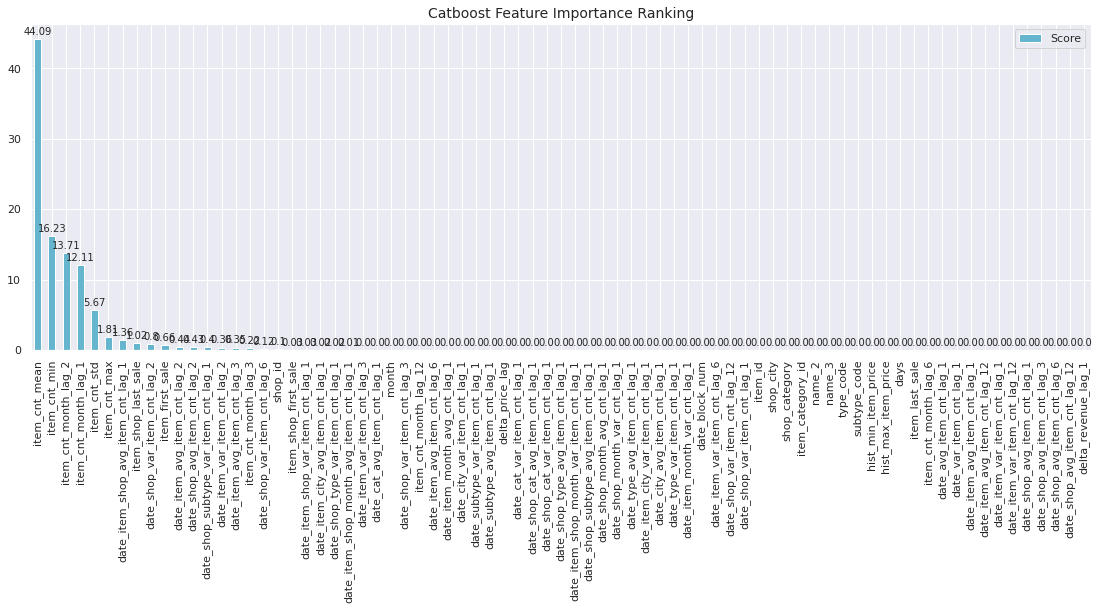

In [163]:
feature_score = pd.DataFrame(list(zip(X_train.dtypes.index, catboost_model.get_feature_importance(Pool(X_train, label=Y_train, cat_features=cat_features)))), columns=['Feature','Score'])
feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')

plt.rcParams["figure.figsize"] = (19, 6)
ax = feature_score.plot('Feature', 'Score', kind='bar', color='c')
ax.set_title("Catboost Feature Importance Ranking", fontsize = 14)
ax.set_xlabel('')
rects = ax.patches
labels = feature_score['Score'].round(2)

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 0.35, label, ha='center', va='bottom')

plt.show()

In [171]:
X_train.columns[catboost_model.get_feature_importance() > 0.001]

Index(['shop_id', 'month', 'item_shop_last_sale', 'item_shop_first_sale',
       'item_first_sale', 'item_cnt_min', 'item_cnt_max', 'item_cnt_mean',
       'item_cnt_std', 'item_cnt_month_lag_1', 'item_cnt_month_lag_2',
       'item_cnt_month_lag_3', 'item_cnt_month_lag_12',
       'date_item_avg_item_cnt_lag_2', 'date_item_avg_item_cnt_lag_3',
       'date_item_avg_item_cnt_lag_6', 'date_item_var_item_cnt_lag_2',
       'date_item_var_item_cnt_lag_3', 'date_shop_avg_item_cnt_lag_2',
       'date_shop_var_item_cnt_lag_2', 'date_shop_var_item_cnt_lag_3',
       'date_shop_var_item_cnt_lag_6', 'date_cat_avg_item_cnt_lag_1',
       'date_shop_type_var_item_cnt_lag_1',
       'date_shop_subtype_var_item_cnt_lag_1',
       'date_item_city_avg_item_cnt_lag_1', 'date_item_month_avg_cnt_lag_1',
       'date_item_shop_avg_item_cnt_lag_1',
       'date_item_shop_var_item_cnt_lag_1',
       'date_item_shop_month_avg_item_cnt_lag_1'],
      dtype='object')

### Catboost predict

In [0]:
catboost_train_pred = catboost_model.predict(X_train)
catboost_val_pred = catboost_model.predict(X_valid)
catboost_test_pred = catboost_model.predict(X_test)

In [168]:
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, catboost_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, catboost_val_pred)))

Train rmse: 0.10440678064175969
Validation rmse: 0.18726608830026162


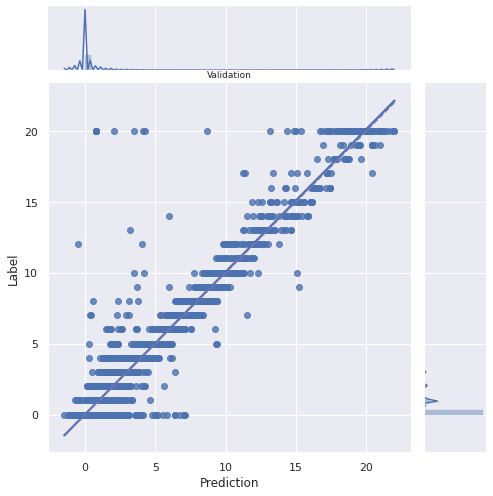

In [170]:
def model_performance_sc_plot(predictions, labels, title):
    # Get min and max values of the predictions and labels.
    min_val = max(max(predictions), max(labels))
    max_val = min(min(predictions), min(labels))
    # Create dataframe with predicitons and labels.
    performance_df = pd.DataFrame({"Label":labels})
    performance_df["Prediction"] = predictions
    # Plot data
    sns.jointplot(y="Label", x="Prediction", data=performance_df, kind="reg", height=7)
    plt.plot([min_val, max_val], [min_val, max_val], 'm--')
    plt.title(title, fontsize=9)
    plt.show()
    
#model_performance_sc_plot(catboost_train_pred, Y_train, 'Train')
model_performance_sc_plot(catboost_val_pred, Y_valid, 'Validation')

### XGBoost

In [0]:
# Use only part of features on XGBoost.
# xgb_features = ['item_cnt','item_cnt_mean', 'item_cnt_std', 'item_cnt_shifted1', 
#                 'item_cnt_shifted2', 'item_cnt_shifted3', 'shop_mean', 
#                 'shop_item_mean', 'mean_item_cnt', 'item_trend']

xgb_features = ['shop_id', 'month', 'item_shop_last_sale', 'item_shop_first_sale',
       'item_first_sale', 'item_cnt_min', 'item_cnt_max', 'item_cnt_mean',
       'item_cnt_std', 'item_cnt_month_lag_1', 'item_cnt_month_lag_2',
       'item_cnt_month_lag_3', 'item_cnt_month_lag_12',
       'date_item_avg_item_cnt_lag_2', 'date_item_avg_item_cnt_lag_3',
       'date_item_avg_item_cnt_lag_6', 'date_item_var_item_cnt_lag_2',
       'date_item_var_item_cnt_lag_3', 'date_shop_avg_item_cnt_lag_2',
       'date_shop_var_item_cnt_lag_2', 'date_shop_var_item_cnt_lag_3',
       'date_shop_var_item_cnt_lag_6', 'date_cat_avg_item_cnt_lag_1',
       'date_shop_type_var_item_cnt_lag_1',
       'date_shop_subtype_var_item_cnt_lag_1',
       'date_item_city_avg_item_cnt_lag_1', 'date_item_month_avg_cnt_lag_1',
       'date_item_shop_avg_item_cnt_lag_1',
       'date_item_shop_var_item_cnt_lag_1',
       'date_item_shop_month_avg_item_cnt_lag_1']
                
xgb_train = X_train[xgb_features]
xgb_val = X_valid[xgb_features]
xgb_test = X_test[xgb_features]

In [0]:
xgb_model = XGBRegressor()

In [0]:
params = {'max_depth':[3, 5, 6,7, 8, 9, 10],
          'n_estimators':[250,100,500],
          'min_child_weight':[250,100,500,1000], 
          'colsample_bytree':[0.5, 0.6, 0.7, 0.8, 0.9],
          "subsample":[0.5, 0.6, 0.7, 0.8, 0.9],
          'eta': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
          }

grid = RandomizedSearchCV(estimator=xgb_model, param_distributions=params, cv=2, n_jobs=-1, n_iter=100)
grid.fit(xgb_val, Y_validation)

[15:25:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


RandomizedSearchCV(cv=2, error_score=nan,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=100,
                                          n_jobs=1, nthread=None,
                                          objective='reg:linear',
                                          random_state=0, reg_alpha=...
                   iid='deprecated', n_iter=100, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.5, 0.6, 0.7, 0.8,
                                               

In [0]:
grid.best_params_

{'colsample_bytree': 0.5,
 'eta': 0.2,
 'max_depth': 8,
 'min_child_weight': 250,
 'n_estimators': 100,
 'subsample': 0.5}

In [0]:
del grid
gc.collect()

3640

In [0]:
best_param_xgb = \
{'colsample_bytree': 0.5,
 'eta': 0.2,
 'max_depth': 8,
 #'min_child_weight': 250,
 'n_estimators': 250,
 'subsample': 0.5
 }

In [0]:
xgb_model = XGBRegressor(**best_param_xgb)
xgb_model.fit(xgb_train, 
              Y_train, 
              eval_metric="rmse", 
              eval_set=[(xgb_train, Y_train), (xgb_val, Y_valid)], 
              verbose=20, 
              early_stopping_rounds=20)

[21:38:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:38:59] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:1.09115	validation_1-rmse:1.06268
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[20]	validation_0-rmse:0.32937	validation_1-rmse:0.343702
[40]	validation_0-rmse:0.197553	validation_1-rmse:0.251585
[60]	validation_0-rmse:0.138543	validation_1-rmse:0.22346
[80]	validation_0-rmse:0.115789	validation_1-rmse:0.211007
[100]	validation_0-rmse:0.099593	validation_1-rmse:0.20668
[120]	validation_0-rmse:0.092515	validation_1-rmse:0.206035
[140]	validation_0-rmse:0.085582	validation_1-rmse:0.203241
[160]	validation_0-rmse:0.08085

### XGBoost feature importance

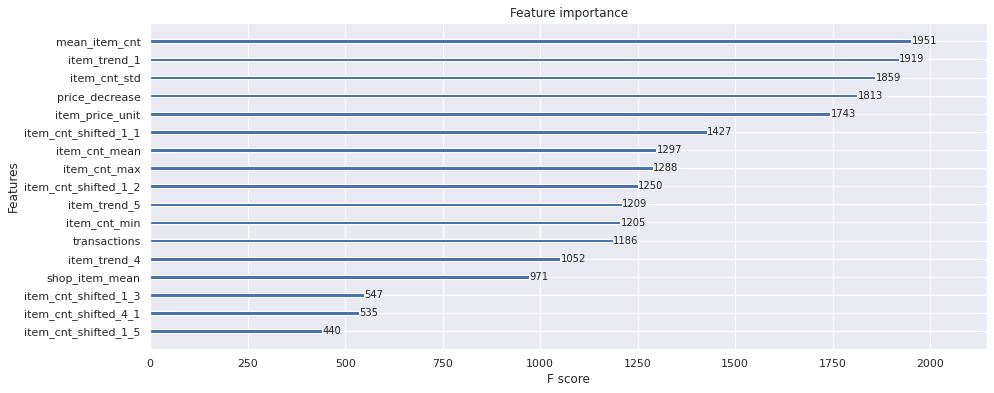

In [0]:
plt.rcParams["figure.figsize"] = (15, 6)
plot_importance(xgb_model)
plt.show()

In [0]:
xgb_train_pred = xgb_model.predict(xgb_train)
xgb_val_pred = xgb_model.predict(xgb_val)
xgb_test_pred = xgb_model.predict(xgb_test)

In [0]:
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, xgb_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, xgb_val_pred)))

Train rmse: 0.07451077238679288
Validation rmse: 0.08892664492470623


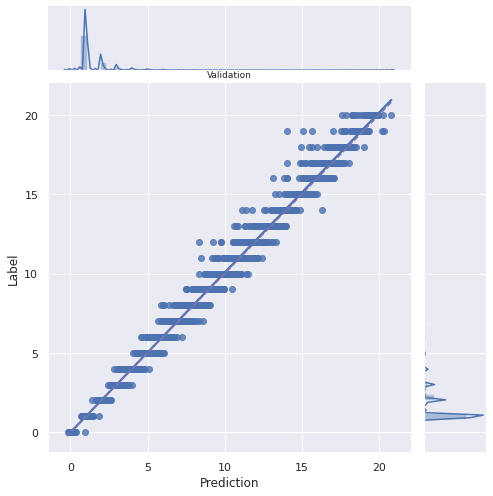

In [0]:
# model_performance_sc_plot(xgb_train_pred, Y_train, 'Train')
model_performance_sc_plot(xgb_val_pred, Y_valid, 'Validation')

### Random Forest

In [0]:
# Use only part of features on random forest.
rf_features = ['shop_id', 'month', 'item_shop_last_sale', 'item_shop_first_sale',
       'item_first_sale', 'item_cnt_min', 'item_cnt_max', 'item_cnt_mean',
       'item_cnt_std', 'item_cnt_month_lag_1', 'item_cnt_month_lag_2',
       'item_cnt_month_lag_3', 'item_cnt_month_lag_12',
       'date_item_avg_item_cnt_lag_2', 'date_item_avg_item_cnt_lag_3',
       'date_item_avg_item_cnt_lag_6', 'date_item_var_item_cnt_lag_2',
       'date_item_var_item_cnt_lag_3', 'date_shop_avg_item_cnt_lag_2',
       'date_shop_var_item_cnt_lag_2', 'date_shop_var_item_cnt_lag_3',
       'date_shop_var_item_cnt_lag_6', 'date_cat_avg_item_cnt_lag_1',
       'date_shop_type_var_item_cnt_lag_1',
       'date_shop_subtype_var_item_cnt_lag_1',
       'date_item_city_avg_item_cnt_lag_1', 'date_item_month_avg_cnt_lag_1',
       'date_item_shop_avg_item_cnt_lag_1',
       'date_item_shop_var_item_cnt_lag_1',
       'date_item_shop_month_avg_item_cnt_lag_1']

rf_train = X_train[rf_features]
rf_val = X_valid[rf_features]
rf_test = X_test[rf_features]

In [0]:
rf_model = RandomForestRegressor()

In [0]:
params = {"n_estimators": [50, 100, 250],
              "max_depth": [3, 5, 7, 10],
              "min_samples_split": [2, 5, 10, 15, 20],
              "min_samples_leaf": [5, 10, 15, 20],
              "max_leaf_nodes": [None, 20, 40]}

grid = RandomizedSearchCV(estimator=rf_model, param_distributions=params, cv=2, n_jobs=-1, n_iter=100)
grid.fit(rf_val, Y_validation)

RandomizedSearchCV(cv=2, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [0]:
grid.best_params_

{'max_depth': 7,
 'max_leaf_nodes': None,
 'min_samples_leaf': 20,
 'min_samples_split': 20,
 'n_estimators': 50}

In [0]:
del grid
gc.collect()

38872

In [0]:
try:
    rf_model = RandomForestRegressor(n_estimators=50, max_depth=7, random_state=0, n_jobs=-1)
    rf_model.fit(rf_train, Y_train)
except:
    pass

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=7, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=50, n_jobs=-1, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [0]:
try:
    rf_train_pred = rf_model.predict(rf_train)
    rf_val_pred = rf_model.predict(rf_val)
    rf_test_pred = rf_model.predict(rf_test)
except:
    pass

In [0]:
try:
    print('Train rmse:', np.sqrt(mean_squared_error(Y_train, rf_train_pred)))
    print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, rf_val_pred)))
except:
    pass

Train rmse: 0.06181357402517945
Validation rmse: 0.05779118833192798


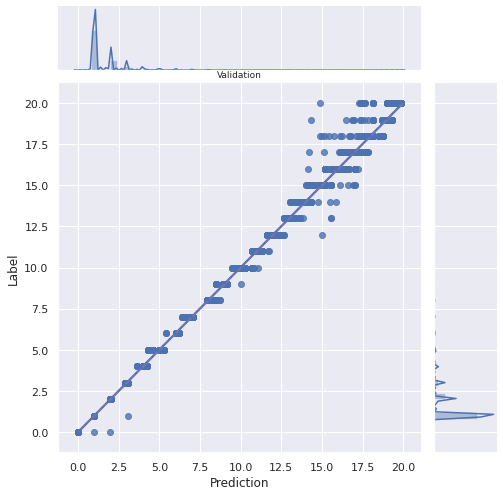

In [0]:
# model_performance_sc_plot(rf_train_pred, Y_train, 'Train')
try:
    model_performance_sc_plot(rf_val_pred, Y_valid, 'Validation')
except:
    pass

### Linear Regression

In [0]:
['shop_id', 'month', 'item_shop_last_sale', 'item_shop_first_sale',
       'item_first_sale', 'item_cnt_min', 'item_cnt_max', 'item_cnt_mean',
       'item_cnt_std', 'item_cnt_month_lag_1', 'item_cnt_month_lag_2',
       'item_cnt_month_lag_3', 'item_cnt_month_lag_12',
       'date_item_avg_item_cnt_lag_2', 'date_item_avg_item_cnt_lag_3',
       'date_item_avg_item_cnt_lag_6', 'date_item_var_item_cnt_lag_2',
       'date_item_var_item_cnt_lag_3', 'date_shop_avg_item_cnt_lag_2',
       'date_shop_var_item_cnt_lag_2', 'date_shop_var_item_cnt_lag_3',
       'date_shop_var_item_cnt_lag_6', 'date_cat_avg_item_cnt_lag_1',
       'date_shop_type_var_item_cnt_lag_1',
       'date_shop_subtype_var_item_cnt_lag_1',
       'date_item_city_avg_item_cnt_lag_1', 'date_item_month_avg_cnt_lag_1',
       'date_item_shop_avg_item_cnt_lag_1',
       'date_item_shop_var_item_cnt_lag_1',
       'date_item_shop_month_avg_item_cnt_lag_1']

Index(['shop_id', 'item_id', 'item_price', 'mean_item_price', 'item_cnt',
       'mean_item_cnt', 'transactions', 'year', 'month', 'item_price_unit',
       'hist_min_item_price', 'hist_max_item_price', 'price_increase',
       'price_decrease', 'price_diff', 'holiday_ft', 'item_cnt_min',
       'item_cnt_max', 'item_cnt_mean', 'item_cnt_std', 'item_cnt_shifted_1_1',
       'item_cnt_shifted_1_2', 'item_cnt_shifted_1_3', 'item_cnt_shifted_1_4',
       'item_cnt_shifted_1_6', 'item_cnt_shifted_1_12', 'item_cnt_shifted_2_1',
       'item_cnt_shifted_2_2', 'item_cnt_shifted_2_3', 'item_cnt_shifted_2_4',
       'item_cnt_shifted_2_6', 'item_cnt_shifted_2_12', 'item_trend_1',
       'item_trend_2', 'shop_city', 'shop_category', 'type_code',
       'subtype_code', 'name_2', 'name_3', 'hist_min_shop_revenue',
       'hist_max_shop_revenue', 'hist_mean_shop_revenue',
       'hist_min_shop_revenue_month', 'hist_max_shop_revenue_month',
       'hist_mean_shop_revenue_month', 'hist_min_category_r

In [0]:
# Use only part of features on linear Regression.
# add item_trend
lr_features = ['item_mean', 'shop_mean', 'item_cnt_min', 'item_cnt_max',
               'item_cnt_mean', 'item_cnt_month_lag_1', 'item_cnt_month_lag_2',
               'item_cnt_std', 'date_item_avg_item_cnt_lag_2', 'date_item_shop_month_avg_item_cnt_lag_1']#, 'item_cnt_shifted2', 'item_cnt_shifted12', 'item_trend', 'shop_item_mean', 'month_mean']

lr_train = X_train[lr_features]
lr_val = X_valid[lr_features]
lr_test = X_test[lr_features]

#### Normalizing features

In [0]:
lr_scaler = MinMaxScaler()
lr_scaler.fit(lr_train)
lr_train = lr_scaler.transform(lr_train)
lr_val = lr_scaler.transform(lr_val)
lr_test = lr_scaler.transform(lr_test)

#### Fitting LR model

In [0]:
lr_model = LinearRegression(n_jobs=-1)
lr_model.fit(lr_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [0]:
lr_train_pred = lr_model.predict(lr_train)
lr_val_pred = lr_model.predict(lr_val)
lr_test_pred = lr_model.predict(lr_test)

In [0]:
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, lr_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, lr_val_pred)))

Train rmse: 1.6152916028739874
Validation rmse: 1.449797246650624


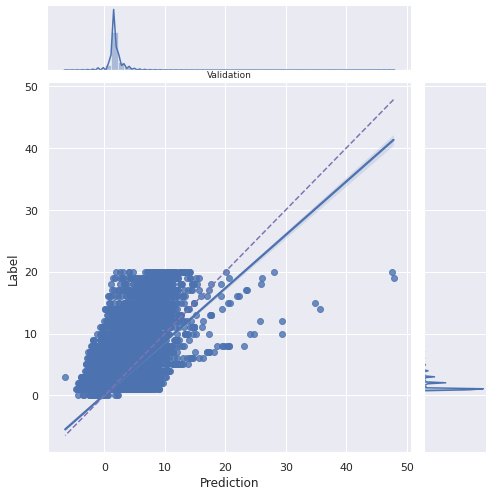

In [0]:
# model_performance_sc_plot(lr_train_pred, Y_train, 'Train')
model_performance_sc_plot(lr_val_pred, Y_valid, 'Validation')

### KNN Regressor

In [0]:
# Use only part of features on KNN.
knn_features = ['date_item_avg_item_cnt_lag_2', 'date_item_avg_item_cnt_lag_3',
       'date_item_avg_item_cnt_lag_6', 'date_item_var_item_cnt_lag_2',
       'date_item_var_item_cnt_lag_3', 'date_shop_avg_item_cnt_lag_2',
       'date_shop_var_item_cnt_lag_2', 'date_shop_var_item_cnt_lag_3',
       'date_shop_var_item_cnt_lag_6', 'date_cat_avg_item_cnt_lag_1',
       'date_shop_type_var_item_cnt_lag_1',
       'date_shop_subtype_var_item_cnt_lag_1',
       'date_item_city_avg_item_cnt_lag_1', 'date_item_month_avg_cnt_lag_1',
       'date_item_shop_avg_item_cnt_lag_1',
       'date_item_shop_var_item_cnt_lag_1',
       'date_item_shop_month_avg_item_cnt_lag_1']

# Subsample train set (using the whole data was taking too long).
X_train_sampled = X_train[:100000]
Y_train_sampled = Y_train[:100000]

knn_train = X_train_sampled[knn_features]
knn_val = X_valid[knn_features]
knn_test = X_test[knn_features]

#### Normalizing features

In [0]:
knn_scaler = MinMaxScaler()
knn_scaler.fit(knn_train)
knn_train = knn_scaler.transform(knn_train)
knn_val = knn_scaler.transform(knn_val)
knn_test = knn_scaler.transform(knn_test)

In [0]:
knn_model = KNeighborsRegressor(n_neighbors=9, leaf_size=13, n_jobs=-1)
knn_model.fit(knn_train, Y_train_sampled)

KNeighborsRegressor(algorithm='auto', leaf_size=13, metric='minkowski',
                    metric_params=None, n_jobs=-1, n_neighbors=9, p=2,
                    weights='uniform')

In [0]:
knn_train_pred = knn_model.predict(knn_train)
knn_val_pred = knn_model.predict(knn_val)
knn_test_pred = knn_model.predict(knn_test)

In [0]:
print('Train rmse:', np.sqrt(mean_squared_error(Y_train_sampled, knn_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, knn_val_pred)))

Train rmse: 1.36966572474121
Validation rmse: 1.2019769119417245


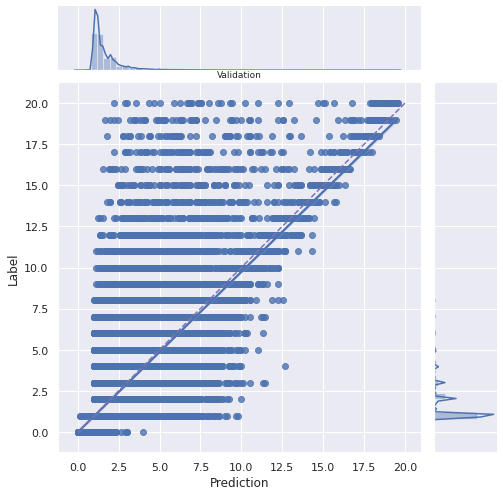

In [0]:
# model_performance_sc_plot(knn_train_pred, Y_train_sampled, 'Train')
model_performance_sc_plot(knn_val_pred, Y_valid, 'Validation')

### Creating first level model

In [0]:
# Dataset that will be the train set of the ensemble model.
first_level = pd.DataFrame(catboost_val_pred, columns=['catboost'])
first_level['xgbm'] = xgb_val_pred
first_level['random_forest'] = rf_val_pred
first_level['linear_regression'] = lr_val_pred
first_level['knn'] = knn_val_pred
first_level['label'] = Y_valid.values
first_level.head()

,catboost,xgbm,random_forest,linear_regression,knn,label
0,1.00,1.00,1.00,2.04,1.67,1
1,1.00,1.00,1.00,1.32,1.00,1
2,1.00,1.00,1.00,2.14,2.00,1
3,2.00,2.00,2.00,4.61,1.67,2
4,1.00,0.99,1.00,0.47,1.44,1


In [0]:
# Dataset that will be the test set of the ensemble model.
first_level_test = pd.DataFrame(catboost_test_pred, columns=['catboost'])
first_level_test['xgbm'] = xgb_test_pred
first_level_test['random_forest'] = rf_test_pred
first_level_test['linear_regression'] = lr_test_pred
first_level_test['knn'] = knn_test_pred
first_level_test.head()

,catboost,xgbm,random_forest,linear_regression,knn
0,1.00,1.03,1.00,0.76,1.78
1,1.00,1.00,1.00,1.07,1.00
2,3.00,2.89,3.00,2.44,2.44
3,1.00,1.00,1.00,1.43,1.00
4,1.00,1.00,1.00,1.07,1.00


## Second level model

In [0]:
meta_model = LinearRegression(n_jobs=-1)

In [0]:
# Drop label from dataset.
first_level.drop('label', axis=1, inplace=True)
meta_model.fit(first_level, Y_valid)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [0]:
# Make predictions on test set using the 1st level models predictions as features
ensemble_pred = meta_model.predict(first_level)
final_predictions = meta_model.predict(first_level_test)

In [0]:
# Ensemble model metrics on validation set
print('Train rmse:', np.sqrt(mean_squared_error(ensemble_pred, Y_valid)))

Train rmse: 0.014540567692900274


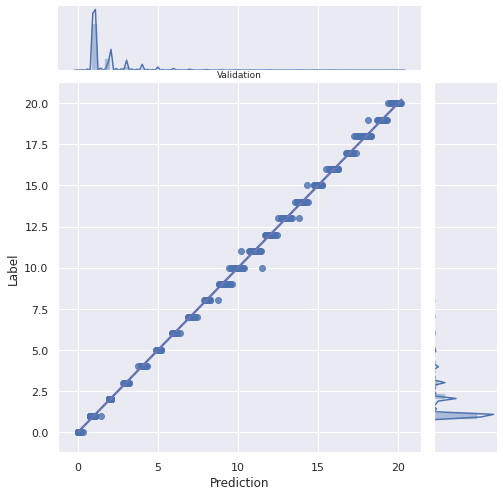

In [0]:
model_performance_sc_plot(ensemble_pred, Y_valid, 'Validation')

# Output

In [0]:
prediction_df = pd.DataFrame(test_df['ID'], columns=['ID'])
prediction_df['item_cnt_month'] = final_predictions.clip(0., 20.)
prediction_df.to_csv('submission.csv', index=False)
prediction_df.head(10)

,ID,item_cnt_month
0,0,1.00
1,1,1.00
2,2,3.00
3,3,1.00
4,4,1.00
5,5,1.00
6,6,3.00
7,7,1.00
8,8,3.00
9,9,1.00


In [0]:
from google.colab import files
files.download('submission.csv') 